<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 6

In this class, we are going to expand on fitting and do some more sophisticated fitting. We will then use our tools to extract the neutrino oscillation paramters of new neturino data. 

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 6.0 Overview of Learning Objectives

In this lecture we will explore how to extract parameters from fitting

- Extacting uncertainty on more than one parameter
- Dealing with Correlated uncertainties
- Fitting Neutrino data
- Neutrino Oscillations
- Profiling Neutrino Parameters
- Convolutions
- Principle Component analysis

<br>
<!--end-block-->

## 6.1 Uncertainty on more than one parameter 

In the end of last week, we started to fit more than one parameter.  What does this mean? Well... this means we minimized two parameters instead of just one. If we have two parameters and they are both gaussian, then the sum of these two paramters is a $\chi^{2}$ of now **2** degrees of freedom. From this, we can start to understand what is going on. 

Let's go to our fit, and perform all the steps of the minimization that `lmfit` just did, but by hand. To do this we will again minimize the function 
\begin{equation}
 f(x,a,b) = a + b \sin(x)
\end{equation}
to the Auger data, which means that we need to find the mimimum of both $a$ and $b$, this means minimizing our likelihood for both $a$ and $b$. 

\begin{equation}
 \frac{\partial \mathcal{L}}{\partial a} = 0 \\
 \frac{\partial \mathcal{L}}{\partial b} = 0 \\
\end{equation}  

or writing this out using the $\chi^{2}$ we have, taking $\sigma = \sqrt{x_{i}}$

\begin{eqnarray}
\chi^{2}(x|a,b) &=& \sum_{i=1}^{N} \frac{(x_{i}-f(x_{i},a,b))^2}{x_{i}}\\
\frac{\partial \chi^{2}(x|a,b) }{\partial a} = 0 \\
\frac{\partial \chi^{2}(x|a,b) }{\partial b} = 0
\end{eqnarray}

The above minima is exactly what we need to do to minimize this. Lets go ahead and do that and look at how things vary. We will do this for each parameter treating them independently. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 26.8040965
    reduced chi-square = 0.95728916
    Akaike info crit   = 0.62072051
    Bayesian info crit = 3.42311528
[[Variables]]
    a:  1072.00653 +/- 5.84870422 (0.55%) (init = 1000)
    b: -50.0226479 +/- 8.24221274 (16.48%) (init = 10)


<Figure size 432x288 with 0 Axes>

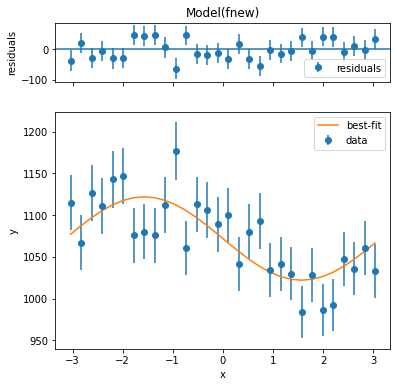

In [49]:
############ This is all code from lecture 4
import numpy as np
import csv
import math
import lmfit
import matplotlib.pyplot as plt
from scipy import optimize as opt

def rad(iTheta):
    return iTheta/180. * math.pi

def rad1(iTheta):
    return iTheta/180. * math.pi-math.pi

def load(label):
    dec=np.array([])
    ra=np.array([])
    az=np.array([])
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile,delimiter=' ')
        for pRow in plots:
            if '#' in pRow[0] or pRow[0]=='':
                continue
            dec = np.append(dec,rad(float(pRow[2])))
            ra  = np.append(ra,rad1(float(pRow[3])))
            az  = np.append(az,rad(float(pRow[4])))
    return dec,ra,az

def prephist(iRA):
    y0, bin_edges = np.histogram(iRA, bins=30)
    x0 = 0.5*(bin_edges[1:] + bin_edges[:-1])
    y0 = y0.astype('float')
    return x0,y0,1./(y0**0.5)

label8='events_a8_1space.dat'
dec,ra8,az=load(label8)
xhist,yhist,xweights=prephist(ra8)


########## Tlast fit code

def fnew(x,a,b):
    pVal=b*np.sin(x)
    return a+pVal

model  = lmfit.Model(fnew)
p = model.make_params(a=1000,b=10)
result = model.fit(data=yhist,x=xhist, params=p, weights=xweights)
lmfit.report_fit(result)
plt.figure()
result.plot()
plt.show()


In [44]:
import scipy.stats as stats
print(stats.norm.cdf(1)-stats.norm.cdf(-1))
def pval(iVal):
    return stats.norm.cdf(iVal)-stats.norm.cdf(-iVal)

def chi2Val(iGausSigma,iNDOF):
    val=stats.chi2.ppf(pval(iGausSigma),iNDOF)
    return val
print(chi2Val(1,2))

0.6826894921370859
2.295748928898636


In [47]:
#This is the new code
def chi2(iX):
    lTot=0
    for val in range(len(yhist)):
        xtest=fnew(xhist[val],iX[0],iX[1])
        lTot = lTot+(1./(xtest+1e-5))*(yhist[val]-xtest)**2
    return lTot

def chi2minX(xval):
    val=chi2([xval,sol.x[1]])
    minval=chi2(sol.x)+1
    return val-minval

def chi2minY(yval):
    val=chi2([sol.x[0],yval])
    minval=chi2(sol.x)+1
    return val-minval

def chi2uncX(sol):
    solX1=opt.root_scalar(chi2minX,bracket=[sol.x[0], sol.x[0]*1.02],method='brentq')
    solX2=opt.root_scalar(chi2minX,bracket=[sol.x[0]*0.98, sol.x[0]],method='brentq')
    print("a:",sol.x[0],"+/-",abs(solX2.root-solX1.root)/2.)
    print("Reminder the Poission uncertianty would be:",math.sqrt(sol.x[0]/40))
    return solX1, solX2

def chi2uncY(sol):
    solY1=opt.root_scalar(chi2minY,bracket=[sol.x[1],    sol.x[1]*1.2],method='brentq')
    solY2=opt.root_scalar(chi2minY,bracket=[sol.x[1]*0.8, sol.x[1]],method='brentq')
    print("b:",sol.x[1],"+/-",abs(solY2.root-solY1.root)/2.)
    return solY1, solY2


#First we minimize
x0 = np.array([1000,10]) # initial conditions
ps = [x0]
sol=opt.minimize(chi2, x0)
print(sol)

      fun: 26.771997460728183
 hess_inv: array([[17.40034693, -0.50416445],
       [-0.50416445, 35.95279697]])
      jac: array([-2.62260437e-06, -4.52995300e-06])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([1073.34616093,  -50.46127062])


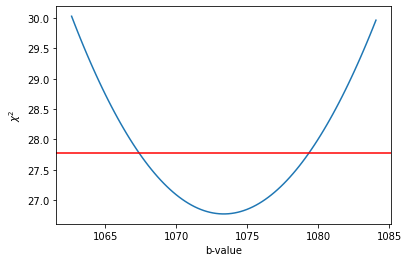

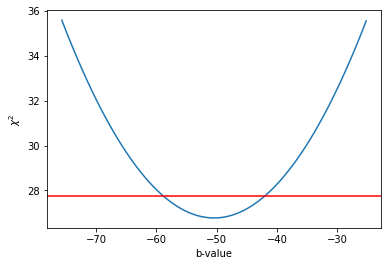

a: 1073.3461609327726 +/- 5.978245804211383
Reminder the Poission uncertianty would be: 5.180121043307706
b: -50.46127061583838 +/- 8.505827129594543


In [46]:
#Scan near the minimum of each value
x = np.linspace(sol.x[0]*0.99,sol.x[0]*1.01, 100)
y = np.linspace(sol.x[1]*0.5,sol.x[1]*1.5, 100)

#Now lets fix one parameter at the minimum, and profile the other
plt.plot(x, chi2([x,sol.x[1]]),label='chi2');
plt.axhline(sol.fun+1, c='red')
plt.xlabel("b-value")
plt.ylabel("$\chi^{2}$")
plt.show()

#Now for the other parameter
plt.plot(y, chi2([sol.x[0],y]),label='chi2');
plt.axhline(sol.fun+1, c='red')
plt.xlabel("b-value")
plt.ylabel("$\chi^{2}$")
plt.show()

solX1, solX2 = chi2uncX(sol)
solY1, solY2 = chi2uncY(sol)

So now we have used our minimizer in 2D to profile the $\chi^{2}$ distribution, and we have obtained an uncertainty by looking at $\Delta \chi^{2}$, and you can see that our semi by-hand manipulation got us to the best parameters of the fitting. Additionally by profiling $\chi^{2}$ in each of the single parameters we obtained the same uncertiinties. 

As a small note our final fitted uncertainty is a little bit larger than the poission uncertainty. In fact for all fits there is a rule that our uncertainties on any parameter have to be larger than a certain number. This bound is known as the Cramér-Rao bound. I won't derive it or go into in detail, but the Cramér-Rao bound states. 
\begin{equation}
\mathrm{Var}(\theta|\hat{\theta}) \geq \frac{1}{\mathcal{I}(\theta)} \\
\mathcal{I}(\theta) = E_{p(X|\theta)}\left[-\frac{\partial^{2}}{\partial\theta^{2}}\log\left(p\left(x|\theta\right)\right)\right]
\end{equation}
Where here we call $\mathcal{I}(\theta)$ the Fisher information. While I don't want to go into this more, this result is powerful because it means that there is limit to when you should stop searching for a best fit. 

To really visualize the whole thing lets make one more plot the 2D $\chi^2$ distribution. 


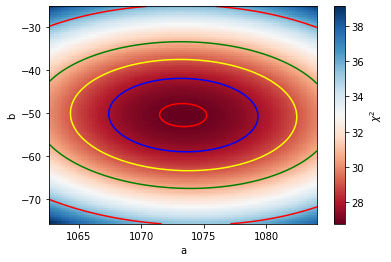

In [24]:
#define the 2D X and Y grid
x = np.linspace(sol.x[0]*0.99,sol.x[0]*1.01, 100) #grid in x
y = np.linspace(sol.x[1]*0.5,sol.x[1]*1.5, 100)#grid in y
X, Y = np.meshgrid(x, y) #2d grid

#Now our z-axis will be the chi2 of the 2D grid (this is complicated code)
Z = np.array([chi2([x,y]) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

#and plot
def plotColorsAndContours(X,Y,Z):
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolor(X,Y,Z,cmap='RdBu')
    cb=fig.colorbar(c, ax=ax)
    plt.xlabel("a")
    plt.ylabel("b")
    cb.set_label("$\chi^{2}$")
    #Now lets plot the isobars of Delta chi^2
    levels = [0.1,1,2.3,4,9, 16, 25, 36, 49, 64, 81, 100]
    for i0 in range(len(levels)):
        levels[i0] = levels[i0]+sol.fun
    c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
    #plt.show()
    
plotColorsAndContours(X,Y,Z)

Now lets got back to our fit, we obtained the 1D results, but we made this 2D plot, and we drew a funny yellow line on it above. What exactly is the uncertainty profile when we are profiling 2 variables at once. Lets go back to our our Taylor expansion result above, but lets write it in terms of all variables $\vec{\theta}$:  

\begin{equation}
\chi^{2}(x_{i},\vec{\theta})=\chi^{2}_{min}(x_{i},\vec{\theta})+\frac{1}{2}(\theta_{i}-\theta_{j})^{T}\frac{\partial^{2}}{\partial \theta_{i}\theta_{0}}\chi^{2}_{min}(x_{i},\vec{\theta}_{0})(\theta_{j}-\theta_{0})
\end{equation}
We can write this out in 2D as:
\begin{equation}
\chi^{2}(x,\vec{\theta})=\chi_{min}^{2}(x,\vec{\theta})+\frac{1}{2}\left(\begin{array}{cc}
\theta_{a}-\theta_{a-min} & \theta_{b}-\theta_{b-min}\end{array}\right)\left(\begin{array}{cc}
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}^{2}} & \frac{\partial^{2}\chi^{2}}{\partial\theta_{a}\partial\theta_{b}}\\
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}\partial\theta_{b}} & \frac{\partial^{2}\chi^{2}}{\partial\theta_{b}^{2}}
\end{array}\right)\left(\begin{array}{c}
\theta_{a}-\theta_{a-min}\\
\theta_{b}-\theta_{b-min}
\end{array}\right)
\end{equation}
Now in the case where $\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}\partial\theta_{b}}\approx0$ we can simplify this distribution by a lot. Lets do it 

\begin{equation}
\chi^{2}(x,\vec{\theta})=\chi_{min}^{2}(x,\vec{\theta})+\frac{1}{2}\left(\begin{array}{cc}
\Delta\theta_{a} & \Delta\theta_{b}\end{array}\right)\left(\begin{array}{cc}
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}^{2}} & 0\\
0 & \frac{\partial^{2}\chi^{2}}{\partial\theta_{b}^{2}}
\end{array}\right)\left(\begin{array}{c}
\Delta\theta_{a}\\
\Delta\theta_{b}
\end{array}\right)
\end{equation}

This all becomes a 2D quadratic equation

\begin{align*}
\chi^{2}(x,\vec{\theta}) & =\chi_{min}^{2}(x,\vec{\theta})+\frac{1}{2}\left(\begin{array}{cc}
\Delta\theta_{a}^{2}\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}^{2}}+ & \Delta\theta_{b}^{2}\frac{\partial^{2}\chi^{2}}{\partial\theta_{b}^{2}}\end{array}\right)\\
 & =\chi_{min}^{2}(x,\vec{\theta})+\left(\begin{array}{cc}
\frac{\Delta\theta_{a}^{2}}{\sigma_{\theta_{a}}^{2}}+ & \frac{\Delta\theta_{b}^{2}}{\sigma_{\theta_{b}}^{2}}\end{array}\right)
\end{align*}

So let's plot this quadratic and compare it to our minimum contours. 

Now before we do this I want to point out one more thing, we are now profiling two parameters at once in this 2D plot, which means the sum of our independent variables will be a $\chi^{2}$ for 2 degrees of freedom. The 1 $\sigma$ confidence interval for 2-degrees of freedom is computed by taking $\Delta \chi^2(x,\nu=2)=x~\mathrm{where~}\mathrm{cdf}\left(\chi^{2}(x,2)=0.683\right)\approx2.3$. This is the yellow line on the contour.


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


[[5.89921129        nan]
 [       nan 8.47971662]]


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


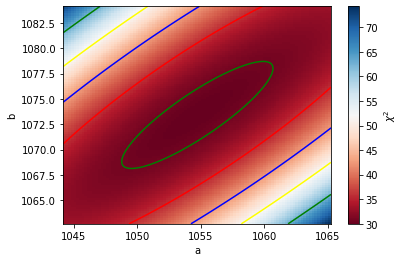

In [48]:
#Lets plot the uncertainties  from hess_inv
print(np.sqrt(2*sol.hess_inv))
#the diagonals are approximately the errors

#Make a the expression in the above equation x and x0 are 2 vectors
def quadratic2D(x,x0,sigma0):
    lVals=x-x0
    lVals=(lVals**2)/(sigma0)/sigma0
    return np.sum(lVals)

plotColorsAndContours(X,Y,Z)

#Now plot the quadratic circles
def plotQuadrticCricles(sigx,sigy):
    levels = [0.1,1,2.3,4,9, 16, 25, 36, 49, 64, 81, 100]
    ZQ = np.array([quadratic2D([x,y],sol.x,[sigx,sigy]) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    c = plt.contour(X, Y, ZQ, levels,colors=['red', 'blue', 'yellow','green'],linestyles='dashed')

sigx=(solX2.root-solX1.root)/2.
sigy=(solY2.root-solY1.root)/2.
plotQuadrticCricles(sigx,sigy)
plt.show()

This gives us the same yellow line for our variance band. If you look close you do see a difference. This makes us beg the question of what happens when $\frac{\partial^{2}\chi^{2}}{\partial \theta_{a}\theta_{b}}\neq0$. Lets try another two parameter fit. To see that, lets try to minimize with a different function. 

### Challenge question:

Make the above 2D contour plot with circles using the minimization function

\begin{equation}
 f(x) = a x + b (1-x)
\end{equation}

Try to use the quadratic2D approximation, why does the 2D quadratic not agree? Why are the uncertainties so far off? 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 30
    # variables        = 2
    chi-square         = 29.8718324
    reduced chi-square = 1.06685116
    Akaike info crit   = 3.87155779
    Bayesian info crit = 6.67395255
[[Variables]]
    a:  1053.22719 +/- 6.95345275 (0.66%) (init = 1000)
    b:  1071.90427 +/- 6.17403792 (0.58%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.872


<Figure size 432x288 with 0 Axes>

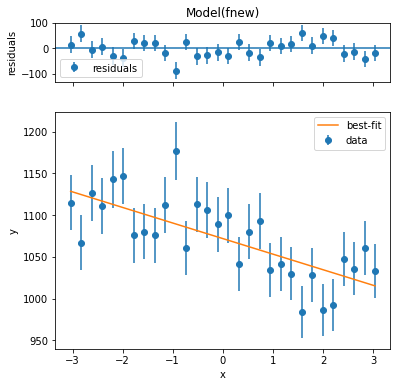

      fun: 29.990341147697194
 hess_inv: array([[22.59365336, 17.34746638],
       [17.34746638, 17.52573421]])
      jac: array([-4.76837158e-06, -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([1054.703102  , 1073.39984514])
a: 1054.7031019957428 +/- 3.305487112159881
Reminder the Poission uncertianty would be: 5.134936956759408
b: 1073.3998451431032 +/- 2.9322206951109138


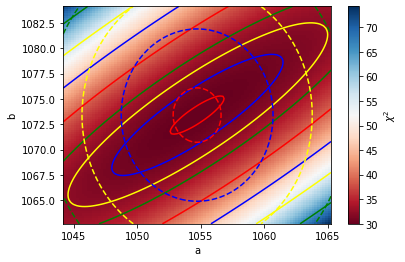

In [36]:
def fnew(x,a,b):
    pVal=b*(1-x)
    return a*x+pVal

model  = lmfit.Model(fnew)
p = model.make_params(a=1000,b=1000)

result = model.fit(data=yhist,x=xhist, params=p, weights=xweights)
lmfit.report_fit(result)
plt.figure()
result.plot()
plt.show()


x0 = np.array([1000,1000])
ps = [x0]
sol=opt.minimize(chi2, x0)
print(sol)

x = np.linspace(sol.x[0]*0.99,sol.x[0]*1.01, 100)
y = np.linspace(sol.x[1]*0.99,sol.x[1]*1.01, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([chi2([x,y]) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
plotColorsAndContours(X,Y,Z)

solX1, solX2 = chi2uncX(sol)
solY1, solY2 = chi2uncY(sol)
plotQuadrticCricles(sigx,sigy)
plt.show()


### 6.2 Dealing with Correlated uncertainties

Now look at our parameters our uncertainty estimate is smaller than what we observed above. Incidently the uncertainties quoted now differ from what we got by varying from the $\chi^{2}$ minimum. What we are doing is moving up and down the 2D plot and looking at $\delta \chi^{2}$. However given the parameters are so correlated, you see that this isn't really a reflection of the true uncertainty in the sense that we can move along $x$ and $y$ and still be within the yellow or even blue ellipse. It's quite clear when you overlap the uncertainty from the quadratic function, which draws circles not ellipses. 

So then what is the right uncertainty? 

Well from our fit using lmfit above we see that the fit outputs a parameter $C(a,b)=0.872$ this is the correlation between the parameters of $a$ and $b$ we also see from our optimization function, we get a computation of something labelled as the hess_inv. This we can write noting the relation of the $\chi^{2}$ Hessian and uncertainties as 
\begin{equation}
\chi^{2}(x_{i},\vec{\theta})=\chi^{2}_{min}(x_{i},\vec{\theta})+\frac{1}{2}(\theta_{i}-\theta_{j})^{T}\frac{\partial^{2}}{\partial \theta_{i}\theta_{0}}\chi^{2}_{min}(x_{i},\vec{\theta}_{0})(\theta_{j}-\theta_{0})
\end{equation}

Which allows us to write the uncertainties as
\begin{equation}
 \frac{2}{\sigma^{2}}=\frac{\partial^{2}\chi^{2}}{\partial\theta_{i}\partial\theta_{j}} \\
 \sigma^{2}    = 2\left(\frac{\partial^{2}\chi^{2}}{\partial\theta_{i}\partial\theta_{j}}\right)^{-1} 
\end{equation}

Now in the case where the off diagonals of the Hessian were zero we had the clear case that the samples are not correlated, and as a consequence, 
\begin{equation}
\left(\begin{array}{cc}
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}^{2}} & 0\\
0 & \frac{\partial^{2}\chi^{2}}{\partial\theta_{b}^{2}}
\end{array}\right)\rightarrow\left(\begin{array}{cc}
\frac{2}{\sigma_{a}^{2}} & 0\\
0 & \frac{2}{\sigma_{b}^{2}}
\end{array}\right)
\end{equation}

Now we have something more complicated. However this is a natural way to define correlations. Lets first verify our intuition for our minimization scheme by taking our $2x2$ Hessian metrix and diagonalizing, computing the eigenvectors and the eigenvalues and then drawing an ellipse. We can diagonalize the matrix as: 
\begin{equation}
A^{-1}2\left(\begin{array}{cc}
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}^{2}} & \frac{\partial^{2}\chi^{2}}{\partial\theta_{a}\partial\theta_{b}}\\
\frac{\partial^{2}\chi^{2}}{\partial\theta_{a}\partial\theta_{b}} & \frac{\partial^{2}\chi^{2}}{\partial\theta_{b}^{2}}
\end{array}\right)^{-1}A=\left(\begin{array}{cc}
\sigma_{1}^{2} & 0\\
0 & \sigma_{2}^{2}
\end{array}\right)
\end{equation}
It is important to note for any N dimensional hessian, provided the determinant is not zero, we can find an basis of independent variables that are not correlated. That is to say we can always diagonalize our Hessian, and the eignevectors of our Hessian are the independent values with variances given by the eigenvalues. 

Knowing how this works, lets play with the Hessian. When we run our minimizer, we get Hessian inverse, let's play with it. 


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


[[5.89921129        nan]
 [       nan 8.47971662]]
values [34.77331264 71.93297516] vectors [[-0.99963151  0.02714504]
 [-0.02714504 -0.99963151]]


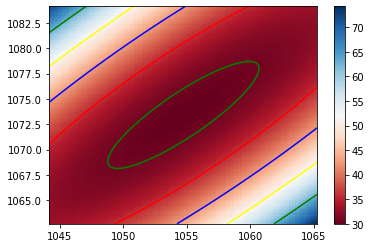

In [50]:
print(np.sqrt(2*sol.hess_inv))
#The diagonals are the uncertainty lmfit quotes

#Really the best way to do this is to get the eigen values using an linear algebra problem
import numpy.linalg as la
w, v=la.eig(2*sol.hess_inv)
print("values",w,"vectors",v)

#Now lets plot the eigenvectors
from matplotlib.patches import Ellipse
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """
    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,angle=np.degrees(theta), **kwargs)

err_ellipse=get_cov_ellipse(2*sol.hess_inv,sol.x,1)
fig, ax = plt.subplots(1, 1)
c = ax.pcolor(X,Y,Z,cmap='RdBu')
fig.colorbar(c, ax=ax)
levels = [0.1,1,2.3,4,9, 16, 25, 36, 49, 64, 81, 100]
for i0 in range(len(levels)):
    levels[i0] = levels[i0]+sol.fun
c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
ax.add_artist(err_ellipse)
plt.show()

From the above we can now formulate how we should describe the uncertinaties in our system. When we had a decorrelated system we had a total uncrtainty in our $\chi^{2}$ given by 
\begin{equation}
\sigma_{tot}^{2} = \sigma_{a}^2+\sigma_{b}^2
\end{equation}

Now we have the full ellipse
\begin{equation}
\sigma_{tot}^{2} = \sigma_{a}^2+\sigma_{b}^2+2\sigma_{ab}
\end{equation}

Where we define that $\sigma_{ab}=\rm{COV(a,b)}$. There are a number of ways to call this variable, they all are equivalent, but lets be careful to write it out. We can write the error matrix in 2D as:
\begin{equation}
\left(\begin{array}{cc}
\sigma_{a}^{2} & {\rm COV}(a,b)\\
{\rm COV}(a,b) & \sigma_{b}^{2}
\end{array}\right)=\sum_{i=1}^{N}\left(\begin{array}{cc}
\left(a_{i}-\bar{a}\right)^{2} & \left(a_{i}-\bar{a}\right)\left(b_{i}-\bar{b}\right)\\
\left(a_{i}-\bar{a}\right)\left(b_{i}-\bar{b}\right) & \left(b_{i}-\bar{b}\right)^{2}
\end{array}\right)
\end{equation}
where on the right side we have written it in terms of the computation over events. Recall that for the a linear regression the slope is just the $\rm{COV(X,Y)/VAR(X)}$, so the covariance matrix is intricately tied with slope. 

We can also write it as the correlation matrix where we normalize by the uncertainties:
\begin{equation}
\rho=\left(\frac{1}{\sigma_{a}}  \frac{1}{\sigma_{b}} \right)^{T}\left(\begin{array}{cc}
1 & \frac{{\rm COV}(a,b)}{\sigma_{a}\sigma_{b}}\\
\frac{{\rm COV}(a,b)}{\sigma_{a}\sigma_{b}} & 1
\end{array}\right)\left(\frac{1}{\sigma_{a}}   \frac{1}{\sigma_{b}} \right) 
\end{equation}

Recall that the covariance is what we originally used to compute the linear slope of the points, this is exactly the same here. In fact, instead of scanning the likelihood analytically we could have sampled the points, and done a linear regression. The resulting slope and line can be related to our eigenvectors. One last think to mention is that if variables are correlated, we can use the correlation to propagate the uncertainties. 
\begin{equation}
\sigma_{f}^{2} = \left(\frac{\partial f}{\partial x}\right)^2\sigma_{x}^2 + \left(\frac{\partial f}{\partial y}\right)^{2}+\left(\frac{\partial f}{\partial x}\right)\left(\frac{\partial f}{\partial y}\right)\sigma_{xy}
\end{equation}

Now lets check we can get the corelation matrix.

In [15]:
#Now lets get the correlation C(a,b) (see below)
w, v=np.linalg.eig(2*sol.hess_inv)
print("c(a,b)",v[0,1]/v[0,0])
print("A deceptively wrong way to get correlation:",sol.hess_inv[0,1]/sol.hess_inv[0,0])

c(a,b) -0.8645411684563379
A deceptively wrong way to get correlation: 0.7678026261640956


Finally, let's compute it from some toy data. 

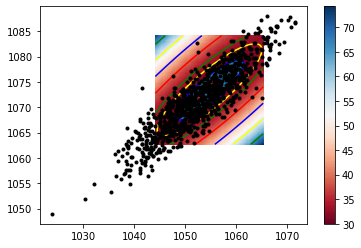

A: 1052.5274425809798 +/- 6.788169178255674
B: 1071.1409575408454 +/- 6.129863268170219
Cov: 36.625135155079064 A Variance: 46.079240792620304 B Variance: 37.57522368646249
Check with Hessian: [[45.18730672 34.69493277]
 [34.69493277 35.05146842]]
Cor: 0.88018870502411 A Variance: 1.0 B Variance: 1.0


In [38]:
import lmfit

def fnew(x,a,b):
    pVal=b*(1-x)
    return a*x+pVal

#Randomly sample points in the above range
def maketoy(iy):
    toy=np.array([])
    for i0 in range(len(iy)):
        pVal = np.random.normal (iy[i0],np.sqrt([iy[i0]]))
        toy = np.append(toy,float(pVal))
    return toy

def fittoy(ibin,iy):
    toy=maketoy(iy)
    model  = lmfit.Model(fnew)
    p = model.make_params(a=1000,b=10)
    xweights=np.array([])
    for i0 in range(len(toy)):
        xweights = np.append(xweights,1./math.sqrt(toy[i0]))
    result = model.fit(data=toy,x=ibin, params=p, weights=xweights)
    return result.params["a"].value,result.params["b"].value

ntoys=1000
lAs=np.array([])
lBs=np.array([])
for i0 in range(ntoys):
    pA,pB=fittoy(xhist,yhist)
    lAs = np.append(lAs,pA)
    lBs = np.append(lBs,pB)

err_ellipse=get_cov_ellipse(2*sol.hess_inv,sol.x, 1)

fig, ax = plt.subplots(1, 1)
c = ax.pcolor(X,Y,Z,cmap='RdBu')
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
ax.add_artist(err_ellipse)
plt.plot(lAs,lBs,c='black',marker='.',linestyle = 'None')
plt.show()

#Now lets run a. linear regression
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

print("A:",lAs.mean(),"+/-",lAs.std())
print("B:",lBs.mean(),"+/-",lBs.std())
print("Cov:",covariance(lAs,lBs),"A Variance:",variance(lAs),"B Variance:",variance(lBs))
print("Check with Hessian:",2*sol.hess_inv)
print("Cor:",covariance(lAs,lBs)/math.sqrt(variance(lAs)*variance(lBs)),"A Variance:",1.,"B Variance:",1.)

## 6.3 Fitting Neutrino data

In this part of the lecture, I would like to fit data from one of the recent Neutrino experiments. The data consists of events at various energies that are observed from neutrino matter iteractions in the NO$\nu$A experiment in Minnesota. Details about this experiment can be found [here]( https://inspirehep.net/files/0a3cd74d55753d242b2a364ce70a5e0e). 

There are 3 type of neutrinos, the electron, muon and $\tau$ neutrino. These neutrinos all interact in roughly the same way, through the weak interaction. Additionally, these neutrinos are all known to be very light. Lastly, it is found that these neutrinos are capable of changing their types over time. What that means is that an electron neutrino can oscillate into a muon neutrino and a $\tau$ neutrino, and a muon the others, and so on. The fact that they oscillate is a bit of a mystery, but what we do know is that this means the way mass is generated for the neutrinos is a different mechanism to the way it interacts.  

To uncerstand the data, we need to consider the key components of this experiment, which is that we first create a beam of neturinos at Fermilab in Illinois, and we then fire this beam at the NO$\nu$A experiment in Minnesota. At NO$\nu$A we check to see what we observe. Since neutrinos intract very weakly, we do this by looking a muon neutrino interactions at a detector at Fermilab, and muon neturino interactions at NO$\nu$A. Between Fermilab and NO$\nu$A what happens is that the neutrinos will oscillate into other neturinos through quantum mechnical mixing. This is a great way to test properties of quantum mechanics, you can read more about that [here](https://arxiv.org/abs/1602.00041). 

That being said, what we expect to compare is a shape by measuring the input beam, with the output shape of the observed events. Since neutrinos interact very weakly, the way we perform this is we put a large detector near the input beam, and we measure the rate of muon neutrinos ,and then we put an even larger detector at the output beam, and we then measure the rate. Lets take a look at this data. 

The data is in root format, like the project. We will use uproot to load the data and see what it is like.  As a reference, you can find the original data location [here](https://nova-docdb.fnal.gov/cgi-bin//ShowDocument?docid=46650).

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
{'neutrino_mode_nue;1': 'TH1D', 'antineutrino_mode_nue;1': 'TH1D', 'antineutrino_mode_numu_quartile1;1': 'TH1D', 'antineutrino_mode_numu_quartile2;1': 'TH1D', 'antineutrino_mode_numu_quartile3;1': 'TH1D', 'antineutrino_mode_numu_quartile4;1': 'TH1D', 'neutrino_mode_numu_quartile1;1': 'TH1D', 'neutrino_mode_numu_quartile2;1': 'TH1D', 'neutrino_mode_numu_quartile3;1': 'TH1D', 'neutrino_mode_numu_quartile4;1': 'TH1D'}


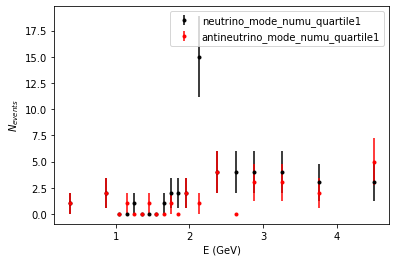

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
!pip install uproot awkward
import uproot

file = uproot.open("NOvA_2020_data_histograms.root")
print(file.classnames())

def plot(iLabel,iFile,iColor):
    bin_edges = iFile[iLabel].axis().edges()
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.xlabel("E (GeV)")
    plt.ylabel("$N_{events}$")
    plt.errorbar(bin_centers,iFile[iLabel].values(),yerr=iFile[iLabel].errors(),marker='.',linestyle = '', color = iColor,label=iLabel)    
    
plot("neutrino_mode_numu_quartile1",file,'black')
plot("antineutrino_mode_numu_quartile1",file,'red')
plt.legend()
plt.show()

    

So, we see two neutrino samples with four quartiles. The quartiles turn out to be different quality selections on the data. Quartile 1 is the most sensitive quartile, whereas Quartile 2,3,4 are less sensitive. How these quartiles are chosen depends on the beam, detector performance, and quality of the reconstruction. For our measurement, we can sum them all up and treat them as one measurement. 

The other label we see is the anti neutrino and neutrino labels are for the type of beam. The beam at fermilab can be run in two different modes. One mode is neutrino mode. In this mode, partilces are fired into the beam that mostly decay into regular neutrinos. The other mode is anti-neutrino mode, in that scenario particles are fired into the beam that decay into anti-neutrinos. 

Suffice it to say there is no gauarantee that anti-particles and particles oscillate with the same parameters, so we keep these samples separate. We can look at the separate quartiles, but lets do that later. 

Instead, lets look at another root file that has the predictions for what we expect the neutrino beam to look like. 

{'prediction_components_nue_fhc;1': 'TDirectory', 'prediction_components_nue_fhc/Signal;1': 'TH1D', 'prediction_components_nue_fhc/Wrong_sign_bkg;1': 'TH1D', 'prediction_components_nue_fhc/Beam_nue_bkg;1': 'TH1D', 'prediction_components_nue_fhc/NC_bkg;1': 'TH1D', 'prediction_components_nue_fhc/NumuCC_bkg;1': 'TH1D', 'prediction_components_nue_fhc/TauCC_bkg;1': 'TH1D', 'prediction_components_nue_fhc/Cosmic_bkg;1': 'TH1D', 'prediction_components_nue_fhc/Total_pred;1': 'TH1D', 'prediction_components_nue_rhc;1': 'TDirectory', 'prediction_components_nue_rhc/Signal;1': 'TH1D', 'prediction_components_nue_rhc/Wrong_sign_bkg;1': 'TH1D', 'prediction_components_nue_rhc/Beam_nue_bkg;1': 'TH1D', 'prediction_components_nue_rhc/NC_bkg;1': 'TH1D', 'prediction_components_nue_rhc/NumuCC_bkg;1': 'TH1D', 'prediction_components_nue_rhc/TauCC_bkg;1': 'TH1D', 'prediction_components_nue_rhc/Cosmic_bkg;1': 'TH1D', 'prediction_components_nue_rhc/Total_pred;1': 'TH1D', 'prediction_components_numu_fhc_Quartile0;1

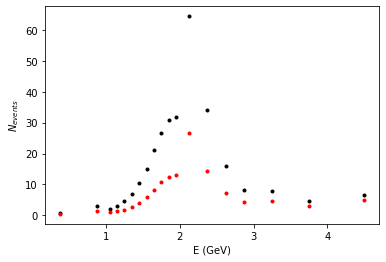

In [21]:
filePred = uproot.open("NOvA_2020_data_release_predictions_with_systs_all_hists.root")
print(filePred.classnames())
plot("prediction_components_numu_fhc_Quartile1/NoOscillations_Total_pred",filePred,'black')
plot("prediction_components_numu_rhc_Quartile1/NoOscillations_Total_pred",filePred,'red')
plt.show()

This file is messy. I won't go into the details but let me put some labels here, to reconcile things. First of all we see prediction_components_rhc_Quartile. Quartile, is the same as before. RHC, and its counterpart FHC standard for "Reverse Horn Current" (RHC) and "Foward Horn Current".   The FHC configuration focuses charged particles with positive polarity (pions,$\pi^{+}$ and Kaons, $K^{+}$) which decay to give a neutrino beam($\nu_{\mu}$) whereas, the RHC configuration focuses charged particles with opposite polarity (pions,$\pi^{-}$ and Kaons, $K^{-}$) that decay to give an anti-neutrino enhanced beam ($\bar{\nu}_{\mu}$). 

Furthermore, the predictions are done under the assumption that there is NoOscillations. Hence, the "NoOscillations" label. 


## 6.4 Neutrino Oscillations

To understand how to fit this data, we follow from the master formula for neutrino oscillations. For those familiar with quantum mechanics, lets write out what the neturino particle eigen-state is:
\begin{equation}
 |\nu_{\mu}\rangle = U^{*}_{\mu1}|\nu_{1}\rangle + U^{*}_{\mu2}|\nu_{2}\rangle + U^{*}_{\mu3}|\nu_{3}\rangle
\end{equation}

Where $U_{\mu i}$ is the muon row of the oscilation matrix. When you time evolve this state and allow the neutrino to move forward a length $L$, you will get that(skipping some steps) 
\begin{eqnarray}
 |\nu_{1}(L)\rangle = e^{-iEt-\vec{p}\cdot\vec{x}}|\nu_{1}\rangle \\
               \approx e^{-i\frac{Lm^{2}_{1}}{2E}}|\nu_{1}(L=0)\rangle
\end{eqnarray}
and, thus, separate mass eigenstates $\nu_{1}$, $\nu_{2}$ and $\nu_{3}$ will evolve at different rates because fo the $m_{1}$ term. What that means is that the probability for neutrinos to still be there can be written by the following master formula: 
\begin{eqnarray}
 P_{\mu\rightarrow\mu} & = &  \left|\langle\nu_{\mu}(L)|\nu_{\mu}(0)\rangle\right|^{2} \\
                       & \approx & 1-\sin^{2}\theta_{23}\sin^{2}\left(\frac{1.27\Delta m^{2}_{23}}{E} L\right)  
\end{eqnarray}
Where $\sin^{2}\theta_{23}$ is the parameter that describes the rate of oscillation between muon neutrinos and $\tau$ neutrinos, and $m^{2}_{23}=m_{3}^2-m_{2}^2$ is the mass difference between the $\tau$ and muon neutrino. You may ask, why is the electron neutrino not involved. It turns out that its rate of oscillations don't impact this measurement. 

Given that, what we can do then is take our original data, divide it by our no oscillation expectation and fit it. In this case, what we would like to extract is not just one parameter, but two parameters $\theta_{23}$ and $m^{2}_{23}$. Let's see if we can get them. 

First, lets prepare our ratio data. First thing is to construct the ratio for each quantile.

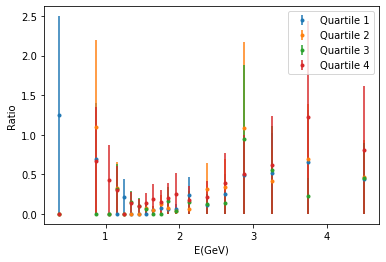

In [22]:
nquartiles=4
label="neutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_fhc_Quartile"
predlabel1="/NoOscillations_Total_pred"
bin_edges=file[label+"1"].axis().edges()
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
def ratio(iQuartile,iPlot=False):
    ytop=file[label+str(i0+1)].values()
    ytop_err=file[label+str(i0+1)].values()
    ybot=filePred[predlabel0+str(i0+1)+predlabel1].values()
    #ybot_err=file[label+str(i0+1)].values() we will skip this since the error is much smaller
    y = ytop/ybot
    y_err = ytop_err/ybot
    if iPlot:
        plt.errorbar(x,y,yerr=y_err,marker='.',linestyle = '',label="Quartile "+str(i0+1))
    return y,y_err
    
for i0 in range(nquartiles):
    ratio(i0,True)
    
plt.xlabel("E(GeV)")
plt.ylabel("Ratio")
plt.legend()
plt.show()

Now, what we would like to do is combine these ratios together. However, we need to do a weighted average weighted by their uncertainties. To do that, we will define for the i-th bin in the ratio $r_{i}$ for the j-th quartile, the [weighted mean](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)
\begin{equation}
 \bar{r}_{i} = \frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} r_{ij}
\end{equation}
This is the maximum likelihood mean for normally distributed independent variables (see above). The weighted variance is then given by propagation of errors as

\begin{equation}
 \sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)^{2}\sum_{j=1}^{4} \frac{1}{\sigma^{4}_{ij}} \sigma^{2}_{ij} \\
  \sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)^{2}\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} \\
\sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)
\end{equation}


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


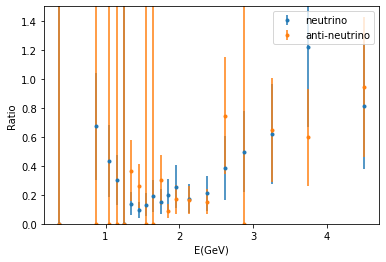

In [23]:
def combinedRatio():
    y,y_err = ratio(0,False)
    y_arrs=np.array([y])
    weight_arrs=np.array([y_err])
    for i0 in range(nquartiles-1):
        y,y_err = ratio(i0,False)
        y_arrs=np.vstack([y_arrs,y])
        weights=1./(y_err**2)
        weights[weights == np.inf] = 0.1
        weight_arrs = np.vstack([weight_arrs,weights])
    #Now do the weighted 
    yout=np.average(y_arrs,weights=weight_arrs,axis=0)
    weights=np.sum(weight_arrs,axis=0)
    return yout,1/weights**0.5,weights**0.5

label="neutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_fhc_Quartile"
y,yerr,weights=combinedRatio()    

label="antineutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_rhc_Quartile"
y_anti,yerr_anti,weights_anti=combinedRatio()    

plt.errorbar(x,y,yerr=yerr,marker='.',linestyle = '',label="neutrino")
plt.errorbar(x,y_anti,yerr=yerr_anti,marker='.',linestyle = '',label="anti-neutrino")
plt.xlabel("E(GeV)")
plt.ylabel("Ratio")
plt.legend()
plt.ylim(0,1.5)
plt.show()

Ok, now that we have the points, lets finally fit the data. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 17
    # variables        = 2
    chi-square         = 4.53860821
    reduced chi-square = 0.30257388
    Akaike info crit   = -18.4500800
    Bayesian info crit = -16.7836533
[[Variables]]
    scale1:  2.34241461 +/- 0.05814050 (2.48%) (init = 1)
    scale2:  0.34204364 +/- 0.01324523 (3.87%) (init = 0.6)
Fit1 chi2 probability:  0.004635484051924957
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 11
    # variables        = 2
    chi-square         = 4.01631702
    reduced chi-square = 0.44625745
    Akaike info crit   = -7.08282950
    Bayesian info crit = -6.28703895
[[Variables]]
    scale1:  2.82315114 +/- 0.11863380 (4.20%) (init = 1)
    scale2:  0.66660988 +/- 0.01813861 (2.72%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale1, scale2) =  0.176
Fit1 chi2 probability:  0.0896647014546639


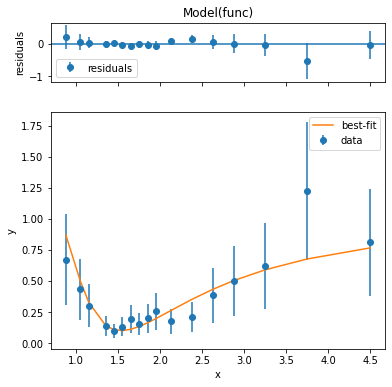

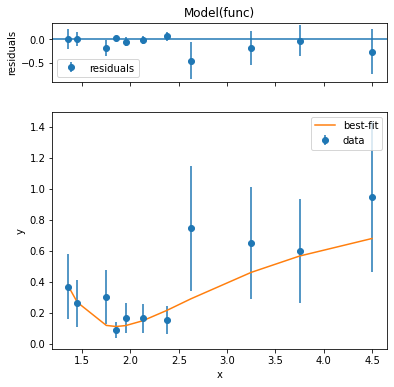

In [24]:
import lmfit
deltam=1*1e-3
L=810
sin2theta23=1.0
def func(x,scale1,scale2):
    xval=1.27*deltam*scale1*L/x
    #val=1-4*scale2*sin2theta23*(1-scale2*sin2theta23)*np.sin(xval)**2
    val=1-4*scale2*(1-scale2)*(np.sin(xval)**2)
    return val

def fit(iX,iY,iWeight):
    model  = lmfit.Model(func)
    p = model.make_params(scale1=1.0,scale2=0.6)
    result = model.fit(x=iX[iY > 0],data=iY[iY > 0], params=p, weights=iWeight[iY > 0])
    lmfit.report_fit(result)
    result.plot()
    print("Fit1 chi2 probability: ",stats.chi2.cdf(result.chisqr,result.nfree))

fit(x,y,weights)
fit(x,y_anti,weights_anti)

## 6.5 Profiling Neutrino Parameters

So we see that neutrinos oscillate. However, what if we want to undrstand how the values of the parameters vary. Lets do a quick scan of the parameters, computing the likelihood for each. 

We can write the 2x the likelihood in terms of the  as the $\chi^{2}$: 

\begin{eqnarray}
\chi^{2}(x|\vec{\theta}) &=& \sum_{i=1}^{N} \frac{(x_{i}-f(x_{i}|\vec{\theta})^2}{\sigma_{i}^{2}} \\
2 \log\left(\mathcal{L}(x|\vec{\theta})\right) &=& \sum_{i=1}^{N} \frac{(x_{i}-f(x_{i}|\vec{\theta})^2}{\sigma_{i}^{2}} \\
\end{eqnarray}

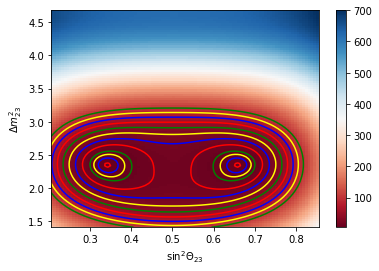

In [35]:
def twoLogLike(var,iX=x,iY=y,iWeights=weights):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    return np.sum(lTot**2)

from scipy import optimize as opt
x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)

def plotScan(sol):
    #Look the same answers, now lets plot the chi2
    xscan = np.linspace(sol.x[0]*0.6,sol.x[0]*2.5, 100)
    yscan = np.linspace(sol.x[1]*0.6,sol.x[1]*2.0, 100)
    X, Y = np.meshgrid(xscan, yscan)
    levels = [0.1,1,2.3,4,9, 16, 25, 36, 49, 64, 81, 100]
    for i0 in range(len(levels)):
        levels[i0] = levels[i0]+sol.fun
    Z = np.array([twoLogLike([xscan,yscan]) for (xscan,yscan) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolor(X,Y,Z,cmap='RdBu')
    fig.colorbar(c, ax=ax)
    c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("$\Delta m^{2}_{23}$")
    plt.show()

plotScan(sol)

So now, we see two circles, what exactly does this mean. Lets profile one variable at a time. 

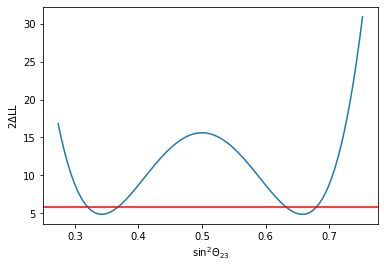

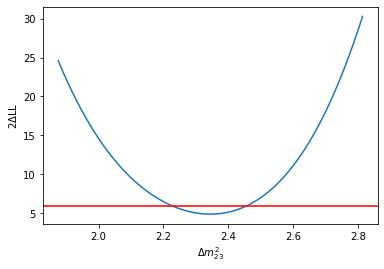

In [26]:
#Now lets fix one parameter at the minimum, and profile the other
def scanAxes(sol):
    xscan = np.linspace(sol.x[0]*0.8,sol.x[0]*2.2, 100)
    yscan = np.linspace(sol.x[1]*0.8,sol.x[1]*1.2, 100)

    xLog = np.array([])
    for pX in xscan:
        xLog = np.append(xLog,twoLogLike(var=[pX,sol.x[1]]))

    yLog = np.array([])
    for pY in yscan:
        yLog = np.append(yLog,twoLogLike(var=[sol.x[0],pY]))

    plt.plot(xscan, xLog,label='loglike');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()

    #Now for the other parameter
    plt.plot(yscan,yLog,label='LL');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\Delta m^{2}_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()
    
scanAxes(sol)

So for $\sin^{2}(\theta_{23})$ there are actually two minima. 

### Challenge

Do the scan for anti-neutrino, do you see a difference in parameters?  A difference in the parameters would mean that anti particles behave differently that regular particles. This is known as [CP-violation](https://en.wikipedia.org/wiki/CP_violation) and can possibly explain why the universe is made of predominatly matter!

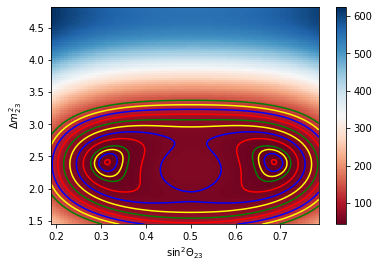

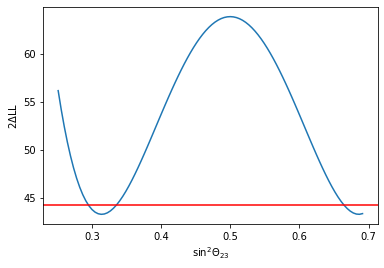

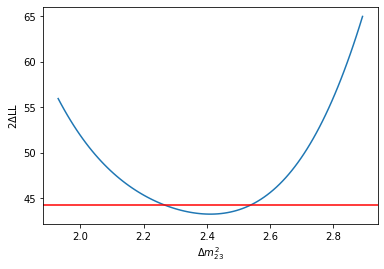

In [201]:
#answer
def twoLogLike(var,iX=x,iY=y_anti,iWeights=weights_anti):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    return np.sum(lTot**2)

x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)
plotScan(sol)
scanAxes(sol)

## 6.6 Combining measurements with constraints from the world

Now lets say, we want to combine this measurment with another measurement. This simplest way to imagine this is that we are minimizing our fit with an additional bin, which is the likelihood that our measurement has deviated from the world average. Our likelihood now will be the product of the probabilities of the best fit parameters, with the new results from NO$\nu$A.  We can write this as

\begin{equation}
2 \log\left(\mathcal{L}(x|\vec{\theta})\right) = 2 \log\left(\mathcal{L}(x|\vec{\theta})\right)_{\rm original} + 
\frac{\left(\sin \theta_{23} - \sin \theta_{23}^{\rm best}\right)^{2}}{\sigma^{2}_{\sin \theta_{23}}} + \frac{\left(\Delta m^{2}_{23} - \Delta m^{2~\rm{best}}_{23}\right)^{2}} {\sigma^{2~\rm{best}}_{\Delta m^{2}_{12}}}
\end{equation}

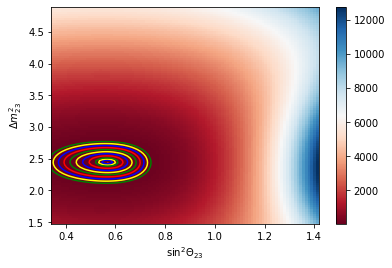

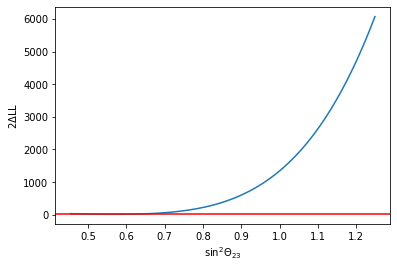

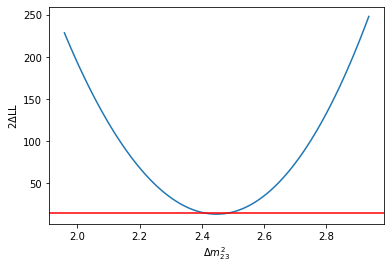

In [27]:
#Now what if we try to add the world's measurement of these parameters into our fit
#https://pdg.lbl.gov/2020/listings/rpp2020-list-neutrino-mixing.pdf
def twoLogLike(var,iX=x,iY=y,iWeights=weights):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    lTot = np.sum(lTot**2)
    sin2worldavg=0.547
    sin2uncavg=0.021
    constraintsin2=((var[0]-sin2worldavg)**2)/(sin2uncavg**2)
    deltamworldavg=2.453
    deltamuncavg=0.034
    constraintdeltam=((var[1]-deltamworldavg)**2)/(deltamuncavg**2)
    return lTot+constraintsin2+constraintdeltam

x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)
plotScan(sol)
scanAxes(sol)

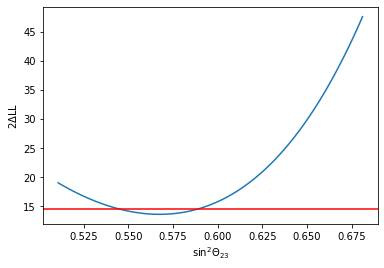

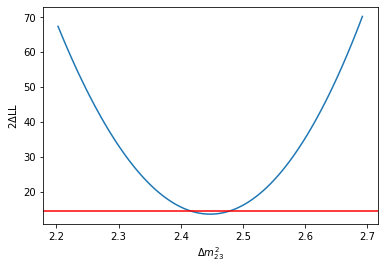

In [205]:
def scanAxes(sol):
    xscan = np.linspace(sol.x[0]*0.9,sol.x[0]*1.2, 100)
    yscan = np.linspace(sol.x[1]*0.9,sol.x[1]*1.1, 100)

    xLog = np.array([])
    for pX in xscan:
        xLog = np.append(xLog,twoLogLike(var=[pX,sol.x[1]]))

    yLog = np.array([])
    for pY in yscan:
        yLog = np.append(yLog,twoLogLike(var=[sol.x[0],pY]))

    plt.plot(xscan, xLog,label='loglike');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()

    #Now for the other parameter
    plt.plot(yscan,yLog,label='LL');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\Delta m^{2}_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()
    
scanAxes(sol)

## 6.7 Convolutions

Convlutions are a critical component of evey good statistical analysis. Its a way to multiply distributions together. 
Lets build convlutions up by scratch and then go from there. 

The core concept of a convolution is that you are effectively multiplying distributions. Given two functions $f(x)$ and $g(x)$, we can define convolutions by 
\begin{eqnarray}
(f*g)(z) &=& \int^{\infty}_{-\infty} f(z-t)g(t)dt
\end{eqnarray}
For data analysis, we usually think about this in the context of probability distribuitons $g$ and $f$. From here, we construct a new probability distribution $(f*g)$. Anyway, lets take a look at how it works. 

To do this, lets first define some functions to convolve. 

In [28]:
#First lets define a triangular distribution
def triangle(x,mean=5):
    Norm=mean*mean
    val=np.where(x <= mean,np.maximum(x,np.zeros(len(x))), np.maximum(2*mean-x,np.zeros(len(x))))
    return val/Norm

#Now define the gaussian
def gaussian(x,mean=0,sigma=1):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 


Now, we need to integrate over a range of one of these functions. 

In [29]:
#Now lets do a convolution by hand
def convolve(f1,f2,x,sigma=1,iMin=-10,iMax=10,iN=2000):
    step=(iMax-iMin)/iN
    pInt=0
    for i0 in range(iN):
            pX   = np.repeat(i0*step+iMin,len(x))
            pVal = f1(x-pX,sigma=sigma)*f2(pX)
            pInt += pVal*step
    return pInt

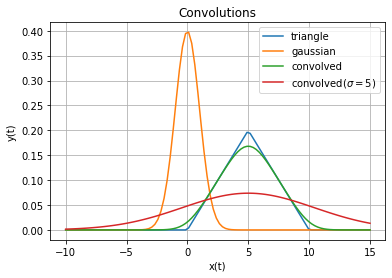

In [36]:
#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
tri_out=triangle(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,triangle,x_in)
conv2_out=convolve(gaussian,triangle,x_in,sigma=5)

ax.plot(x_in,tri_out,label='triangle')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=5$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

### 6.8 Principle Component Analysis

Finally, I would like to say that this method of finding the ellipse is our first deep learning method.
This procedure of computing the covariance matrix, and finding the eigenvectors is known as  principle component analysis or PCA. Lets run it on our example and look From https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

First, what we can do is look at our old correlated fit. All this will do is get the eigenvectors and values for our 2D plot.

PCA vectors
[[ 0.7490535   0.66250951]
 [-0.66250951  0.7490535 ]]
PCA values
[73.38797434  5.18027739]
Old Eigen vectors [75.18250443  5.0562707 ] values [[ 0.75648432 -0.65401183]
 [ 0.65401183  0.75648432]]


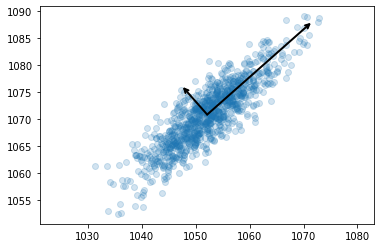

In [31]:
from sklearn.decomposition import PCA
X=(np.vstack([lAs,lBs])).T
pca = PCA(n_components=2)
pca.fit(X)
print("PCA vectors")
print(pca.components_)
print("PCA values")
print(pca.explained_variance_)
print("Old Eigen","vectors",w,"values",v)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',linewidth=2,shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(lAs, lBs, alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Finally, we can try this on an ML dataset. Lets take images with many pixels and treat each pixel as a separate dimension. We can then run the decomposition on the image by decomposing the n-pixel by n-pixel correlation matrix.

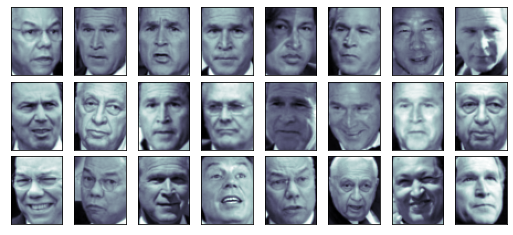

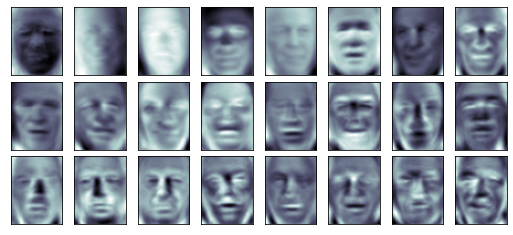

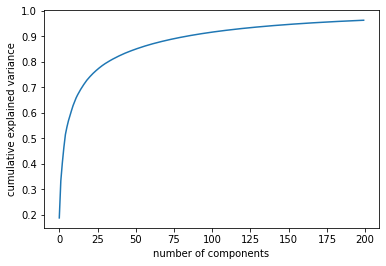

In [37]:
#Now lets do it ML style for fun
#Load some faces of images
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Lets plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='bone')
    
#Fit them to PCA 
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(200)
pca.fit(faces.data)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Lets plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
plt.show()
    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


Finally, what we can do is plot our world leaders just by taking the first 80 eigenvectors of our sample. What we have effectively done is compress our original image into 80 values thats it!

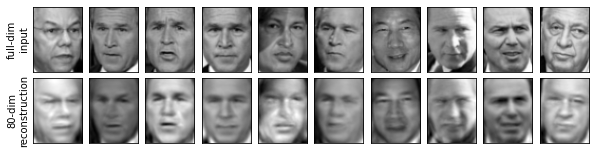

In [33]:
# Compute the components and projected faces
pca = RandomizedPCA(80).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('80-dim\nreconstruction');